# Using CharRNN Model and Vocab to train SMILES Generation Model

In [1]:
# change to the directory of the working file
%cd ..

/home/hudongcheng/Desktop/bo_osda_generator


In [2]:
import pandas as pd
from rdkit import Chem
import numpy as np
import random
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime

# import the necessary modules
from datasets.data_loader import *
from models.RNN import *
from models.loss import InfoNCELoss
from models.trfm import *
from utils.utils import *
from utils.metrics import *
from utils.plot_figures import *
from utils.build_vocab import *

In [3]:
cudnn.benchmark = True
cudnn.enabled = True

train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []
train_ce_loss_history = []
test_ce_loss_history = []
train_info_loss_history = []
test_info_loss_history = []

log_dir = './logs/'
save_best_weight_path = './checkpoints/'

now = datetime.now().strftime('%Y-%m-%d-%H-%M-%S')

In [4]:
PAD = 0
UNK = 1
EOS = 2
SOS = 3
MASK = 4
MAX_LEN = 220

In [5]:
# read the data from the file
train_data = pd.read_csv('./data/train_contrastive_dataset.csv')
test_data = pd.read_csv('./data/test_contrastive_dataset.csv')

vocab = WordVocab.load_vocab('./model_hub/vocab.pkl')
print('the vocab size is :', len(vocab))

charlen = len(vocab)
print('the total num of charset is :', charlen)

the vocab size is : 45
the total num of charset is : 45


In [6]:
cudnn.benchmark = True
lr = 4e-6
batch_size = 64
epoch = 15
InfoNCEloss_weight = 0.1

manual_seed = 42
random.seed(manual_seed)
torch.manual_seed(manual_seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
# create the dataset and dataloader
# train_dataset = Contrastive_Seq2seqDataset(train_data, vocab, MAX_LEN)
# test_dataset = Contrastive_Seq2seqDataset(test_data, vocab, MAX_LEN)
train_dataset = Contrastive_Seq2seqDataset_random(train_data, vocab, MAX_LEN)
test_dataset = Contrastive_Seq2seqDataset_random(test_data, vocab, MAX_LEN)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# load the model
model = RNNModel(input_size=charlen, 
                 synthesis_dim=24, 
                 embedding_dim=128,
                 hidden_size=256,
                 num_layers=3,
                 dropout=0,
                 vocab_size=charlen).to(device)

# load model
trfm = TrfmSeq2seq(charlen, 256, charlen, 4).to(device)
trfm.load_state_dict(torch.load('./model_hub/trfm_new_2_10000.pkl'))
trfm.eval()

# set trfm gradient to false which won't be updated
for param in trfm.parameters():
    param.requires_grad = False

# loss
loss_func = torch.nn.CrossEntropyLoss(ignore_index=PAD)
optim = torch.optim.Adam(model.parameters(), lr=6e-4)
total = sum(p.numel() for p in model.parameters())
print('total parameters: %0.2fM' % (total / 1e6))

100%|██████████| 14803/14803 [00:00<00:00, 51515.46it/s]


total parameters: 0.39M


In [8]:
# train function
def train(model, trfm, train_dataloader, loss_func, optim, device, weight=0.1):
    model.train()
    total_loss = 0
    total_loss_crossentropy = 0
    total_loss_infonce = 0
    total_acc = 0
    total_num = 0
    for i, (zeo, syn, tgt, positive_smiles, negative_smiles) in enumerate(tqdm(train_dataloader)):
        zeo = zeo.to(device)
        syn = syn.to(device)
        tgt = tgt.to(device)
        positive_smiles = positive_smiles.to(device)
        negative_smiles = negative_smiles.to(device)
        
        # concat zeo and syn as the input (prop)
        synthesis_condition = torch.cat([zeo, syn], dim=-1)
        tgt_input = tgt[:, :-1].contiguous()
        tgt_label = tgt[:, 1:].contiguous()
        
        # forward
        optim.zero_grad()
        logits, _ = model(synthesis_condition, tgt_input)
        
        # Compute CrossEntropy Loss
        logits_reshaped = logits.view(-1, logits.size(-1))
        tgt_label_reshaped = tgt_label.view(-1)
        loss_ce = loss_func(logits_reshaped, tgt_label_reshaped)
        
        # calculate the accuracy
        pred = torch.argmax(logits, dim=-1)
        num_correct = (pred == tgt_label) & (tgt_label != PAD)
        num_words = (tgt_label != PAD).sum().item()
        
        # Gumbel-Softmax Sampling
        # logits: [batch_size, seq_len, vocab_size]
        samples = F.gumbel_softmax(logits, tau=1.0, hard=True)
        samples_indices = samples.argmax(dim=-1) # [batch_size, seq_len]
        # add the start token to the samples
        stared_token = torch.ones(samples_indices.size(0), 1, dtype=torch.long).fill_(SOS).to(device)
        samples_indices = torch.cat([stared_token, samples_indices], dim=-1)
        
        # Compute InfoNCE Loss
        loss_infonce = InfoNCELoss(samples_indices, positive_smiles, negative_smiles, trfm, temperature=0.07)
        
        # combine the two loss
        loss = loss_ce + weight * loss_infonce
        
        # backward
        loss.backward()
        optim.step()
        
        # statistics
        total_loss += loss.item()
        total_loss_crossentropy += loss_ce.item()
        total_loss_infonce += loss_infonce.item()
        total_acc += num_correct.sum().item()
        total_num += num_words
    return total_loss / len(train_dataloader), total_acc / total_num, total_loss_crossentropy / len(train_dataloader), total_loss_infonce / len(train_dataloader)

In [9]:
def evaluate(model, trfm, test_dataloader, loss_func, device, weight=0.1):
    model.eval()
    total_loss = 0
    total_loss_crossentropy = 0
    total_loss_infonce = 0
    total_acc = 0
    total_num = 0
    with torch.no_grad():
        for i, (zeo, syn, tgt, positive_smiles, negative_smiles) in enumerate(tqdm(test_dataloader)):
            zeo = zeo.to(device)
            syn = syn.to(device)
            tgt = tgt.to(device)
            positive_smiles = positive_smiles.to(device)
            negative_smiles = negative_smiles.to(device)
            
            # concat zeo and syn as the input (prop)
            synthesis_condition = torch.cat([zeo, syn], dim=-1)
            tgt_input = tgt[:, :-1].contiguous()
            tgt_label = tgt[:, 1:].contiguous()
            
            # forward
            logits, _ = model(synthesis_condition, tgt_input)
            
            # Compute CrossEntropy Loss
            logits_reshaped = logits.view(-1, logits.size(-1))
            tgt_label_reshaped = tgt_label.view(-1)
            loss_ce = loss_func(logits_reshaped, tgt_label_reshaped)
            
            # calculate the accuracy
            pred = torch.argmax(logits, dim=-1)
            num_correct = (pred == tgt_label) & (tgt_label != PAD)
            num_words = (tgt_label != PAD).sum().item()
            
            # Gumbel-Softmax Sampling
            # logits: [batch_size, seq_len, vocab_size]
            samples = F.gumbel_softmax(logits, tau=1.0, hard=True)
            samples_indices = samples.argmax(dim=-1) # [batch_size, seq_len]
            
            # Compute InfoNCE Loss
            loss_infonce = InfoNCELoss(samples_indices, positive_smiles, negative_smiles, trfm, temperature=0.07)
            # add the start token to the samples
            stared_token = torch.ones(samples_indices.size(0), 1, dtype=torch.long).fill_(SOS).to(device)
            samples_indices = torch.cat([stared_token, samples_indices], dim=-1)
            
            # combine the two loss
            loss = loss_ce + weight * loss_infonce
            
            # statistics
            total_loss += loss.item()
            total_loss_crossentropy += loss_ce.item()
            total_loss_infonce += loss_infonce.item()
            total_acc += num_correct.sum().item()
            total_num += num_words
    return total_loss / len(test_dataloader), total_acc / total_num, total_loss_crossentropy / len(test_dataloader), total_loss_infonce / len(test_dataloader)

In [10]:
# train the model
for i in range(epoch):
    train_loss, train_acc, train_ce, train_info = train(model, trfm, train_dataloader, loss_func, optim, device)
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    train_ce_loss_history.append(train_ce)
    train_info_loss_history.append(train_info)
    print('epoch: %d, train loss: %.4f, train acc: %.4f, train crossentropy loss: %.4f, train infonce loss: %.4f' % (i, train_loss, train_acc, train_ce, train_info))
    test_loss, test_acc, test_ce, test_info = evaluate(model, trfm, test_dataloader, loss_func, device)
    test_loss_history.append(test_loss)
    test_acc_history.append(test_acc)
    test_ce_loss_history.append(test_ce)
    test_info_loss_history.append(test_info)
    print('epoch: %d test loss: %.4f, test acc: %.4f, test crossentropy loss: %.4f, test infonce loss: %.4f' % (i, test_loss, test_acc, test_ce, test_info))
    if i == 0:
        best_acc = test_acc
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), save_best_weight_path + 'best_charnn_contrastive_model.pth')
    torch.save(model.state_dict(), save_best_weight_path + 'last_charnn_contrastive_model.pth')
    
    # save every epoch to ./checkpoints/ddc
    torch.save(model.state_dict(), save_best_weight_path + '/charnn/charnn_contrastive_model_epoch_%d.pth' % i)

100%|██████████| 2265/2265 [18:46<00:00,  2.01it/s]


epoch: 0, train loss: 1.1797, train acc: 0.7416, train crossentropy loss: 0.7310, train infonce loss: 4.4862


100%|██████████| 232/232 [01:53<00:00,  2.04it/s]


epoch: 0 test loss: 1.0381, test acc: 0.7838, test crossentropy loss: 0.5897, test infonce loss: 4.4840


100%|██████████| 2265/2265 [18:46<00:00,  2.01it/s]


epoch: 1, train loss: 0.9844, train acc: 0.7951, train crossentropy loss: 0.5360, train infonce loss: 4.4840


100%|██████████| 232/232 [01:53<00:00,  2.04it/s]


epoch: 1 test loss: 1.0004, test acc: 0.7943, test crossentropy loss: 0.5545, test infonce loss: 4.4586


100%|██████████| 2265/2265 [18:46<00:00,  2.01it/s]


epoch: 2, train loss: 0.9582, train acc: 0.8028, train crossentropy loss: 0.5100, train infonce loss: 4.4824


100%|██████████| 232/232 [01:53<00:00,  2.04it/s]


epoch: 2 test loss: 0.9787, test acc: 0.7993, test crossentropy loss: 0.5345, test infonce loss: 4.4419


100%|██████████| 2265/2265 [18:46<00:00,  2.01it/s]


epoch: 3, train loss: 0.9223, train acc: 0.8136, train crossentropy loss: 0.4747, train infonce loss: 4.4761


100%|██████████| 232/232 [01:53<00:00,  2.04it/s]


epoch: 3 test loss: 0.9527, test acc: 0.8068, test crossentropy loss: 0.5119, test infonce loss: 4.4082


100%|██████████| 2265/2265 [18:46<00:00,  2.01it/s]


epoch: 4, train loss: 0.8909, train acc: 0.8219, train crossentropy loss: 0.4479, train infonce loss: 4.4294


100%|██████████| 232/232 [01:53<00:00,  2.04it/s]


epoch: 4 test loss: 0.9260, test acc: 0.8138, test crossentropy loss: 0.4876, test infonce loss: 4.3842


100%|██████████| 2265/2265 [18:46<00:00,  2.01it/s]


epoch: 5, train loss: 0.8758, train acc: 0.8261, train crossentropy loss: 0.4339, train infonce loss: 4.4183


100%|██████████| 232/232 [01:53<00:00,  2.04it/s]


epoch: 5 test loss: 0.9191, test acc: 0.8164, test crossentropy loss: 0.4800, test infonce loss: 4.3909


100%|██████████| 2265/2265 [18:46<00:00,  2.01it/s]


epoch: 6, train loss: 0.8641, train acc: 0.8303, train crossentropy loss: 0.4217, train infonce loss: 4.4235


100%|██████████| 232/232 [01:53<00:00,  2.04it/s]


epoch: 6 test loss: 0.9137, test acc: 0.8181, test crossentropy loss: 0.4730, test infonce loss: 4.4076


100%|██████████| 2265/2265 [18:46<00:00,  2.01it/s]


epoch: 7, train loss: 0.8825, train acc: 0.8236, train crossentropy loss: 0.4397, train infonce loss: 4.4278


100%|██████████| 232/232 [01:53<00:00,  2.04it/s]


epoch: 7 test loss: 0.9577, test acc: 0.8021, test crossentropy loss: 0.5153, test infonce loss: 4.4236


100%|██████████| 2265/2265 [18:46<00:00,  2.01it/s]


epoch: 8, train loss: 0.8649, train acc: 0.8293, train crossentropy loss: 0.4216, train infonce loss: 4.4328


100%|██████████| 232/232 [01:53<00:00,  2.04it/s]


epoch: 8 test loss: 0.8968, test acc: 0.8212, test crossentropy loss: 0.4609, test infonce loss: 4.3596


100%|██████████| 2265/2265 [18:46<00:00,  2.01it/s]


epoch: 9, train loss: 0.8408, train acc: 0.8371, train crossentropy loss: 0.3992, train infonce loss: 4.4157


100%|██████████| 232/232 [01:53<00:00,  2.04it/s]


epoch: 9 test loss: 0.8943, test acc: 0.8229, test crossentropy loss: 0.4585, test infonce loss: 4.3578


100%|██████████| 2265/2265 [18:46<00:00,  2.01it/s]


epoch: 10, train loss: 0.8418, train acc: 0.8368, train crossentropy loss: 0.4001, train infonce loss: 4.4165


100%|██████████| 232/232 [01:53<00:00,  2.04it/s]


epoch: 10 test loss: 0.8880, test acc: 0.8258, test crossentropy loss: 0.4477, test infonce loss: 4.4030


100%|██████████| 2265/2265 [18:46<00:00,  2.01it/s]


epoch: 11, train loss: 0.8286, train acc: 0.8408, train crossentropy loss: 0.3876, train infonce loss: 4.4098


100%|██████████| 232/232 [01:53<00:00,  2.04it/s]


epoch: 11 test loss: 0.8891, test acc: 0.8258, test crossentropy loss: 0.4487, test infonce loss: 4.4038


100%|██████████| 2265/2265 [18:46<00:00,  2.01it/s]


epoch: 12, train loss: 0.8328, train acc: 0.8401, train crossentropy loss: 0.3897, train infonce loss: 4.4313


100%|██████████| 232/232 [01:53<00:00,  2.04it/s]


epoch: 12 test loss: 0.8957, test acc: 0.8225, test crossentropy loss: 0.4553, test infonce loss: 4.4043


100%|██████████| 2265/2265 [18:46<00:00,  2.01it/s]


epoch: 13, train loss: 0.8253, train acc: 0.8426, train crossentropy loss: 0.3823, train infonce loss: 4.4304


100%|██████████| 232/232 [01:53<00:00,  2.04it/s]


epoch: 13 test loss: 0.8785, test acc: 0.8287, test crossentropy loss: 0.4389, test infonce loss: 4.3961


100%|██████████| 2265/2265 [18:46<00:00,  2.01it/s]


epoch: 14, train loss: 0.8284, train acc: 0.8414, train crossentropy loss: 0.3851, train infonce loss: 4.4330


100%|██████████| 232/232 [01:53<00:00,  2.04it/s]

epoch: 14 test loss: 0.8794, test acc: 0.8277, test crossentropy loss: 0.4394, test infonce loss: 4.4003


In [11]:
def generate_rnn(model, start_sequence, condition_props, max_length, vocab, device, temperature=1.0, top_k=0):
    """
    Autoregressive generation process for a GPT model.

    Args:
        model (RNN): The pre-trained GPT model for token generation.
        start_sequence (torch.Tensor): The initial sequence to start generation (batch_size, seq_length).
        condition_props (torch.Tensor): The conditional property vector (batch_size, num_props).
        max_length (int): The maximum length of the generated sequence.
        vocab: The vocabulary object for encoding and decoding SMILES strings.
        device (torch.device): The device on which to run the generation.
        temperature (float): Temperature parameter for sampling; higher values increase randomness.
        top_k (int): Limits sampling to top-k logits; if 0, no top-k sampling is applied.

    Returns:
        List[str]: A list of generated SMILES strings.
    """
    model.eval()
    batch_size = start_sequence.size(0)
    generated_sequences = start_sequence.clone().to(device)  # Clone and move to device

    for _ in range(max_length - start_sequence.size(1)):
        # Get the current sequence length
        current_length = generated_sequences.size(1)

        # Forward pass through the model
        logits, _ = model(condition_props, generated_sequences)  # (batch_size, seq_length, vocab_size)

        # Extract the logits for the last time step
        next_token_logits = logits[:, -1, :]  # (batch_size, vocab_size)

        # Apply temperature scaling
        next_token_logits = next_token_logits / temperature

        # Apply top-k filtering
        if top_k > 0:
            top_k_logits, top_k_indices = torch.topk(next_token_logits, top_k, dim=-1)
            mask = torch.full_like(next_token_logits, float('-inf'))
            mask.scatter_(dim=-1, index=top_k_indices, src=top_k_logits)
            next_token_logits = mask

        # Convert logits to probabilities
        next_token_probs = F.softmax(next_token_logits, dim=-1)

        # Sample from the probability distribution
        next_token = torch.multinomial(next_token_probs, num_samples=1)  # (batch_size, 1)
        
        # Get the most likely next token
        # next_token = torch.argmax(next_token_logits, dim=-1, keepdim=True)

        # Append the generated token to the sequence
        generated_sequences = torch.cat([generated_sequences, next_token], dim=1)

        # Check if all sequences have reached the end token
        if all(next_token[i].item() == EOS for i in range(batch_size)):
            break

    # Decode the generated sequences into SMILES strings
    generated_smiles = []
    for seq in generated_sequences:
        # Convert indices to characters, ignoring padding and start tokens
        # check if the generated sequence contains the end token, if meet, stop decoding
        smiles = ''
        for idx in seq:
            if idx.item() == EOS:
                break
            elif idx.item() != PAD and idx.item() != SOS:
                smiles += vocab.itos[idx.item()]
        generated_smiles.append(smiles)

    return generated_smiles


In [12]:
# generate the smiles for the test dataset
generated_smile = []
target_smile = []
for i, (zeo, syn, tgt, _, _) in enumerate(tqdm(test_dataloader)):
    zeo = zeo.to(device)
    syn = syn.to(device)
    tgt = tgt.to(device)
    condition_synthesis = torch.cat([zeo, syn], dim=1)
    generated_smiles = generate_rnn(model, tgt[:, :2], condition_synthesis, MAX_LEN, vocab, device, 0.5)
    generated_smile.extend(generated_smiles)
    # convert the tgt to smiles
    tgt_smiles = []
    for seq in tgt:
        smiles = ''
        for idx in seq:
            if idx.item() == EOS:
                break
            elif idx.item() != PAD and idx.item() != SOS:
                smiles += vocab.itos[idx.item()]
        tgt_smiles.append(smiles)
    target_smile.extend(tgt_smiles)

100%|██████████| 232/232 [03:25<00:00,  1.13it/s]


In [13]:
# calculate the metrics
print('Validity rate:', validity_rate(generated_smiles))
print('Uniqueness rate:', uniqueness_rate(generated_smiles))
print('Novelty rate:', novelty_rate(generated_smiles, target_smile))
print('Reconstructability rate:', reconstructability_rate(generated_smiles, target_smile))
print('Novelty rate:', novelty_rate(generated_smiles, target_smile))
print('IntDiv:', IntDiv(generated_smiles))
# print('KL-divergence:', KL_divergence(target_smile), generated_smile))
print('FCD score:', FCD_score(target_smile, generated_smile))

Validity rate: 1.0
Uniqueness rate: 0.8947368421052632
Novelty rate: 0.8235294117647058
Reconstructability rate: 0.17647058823529413
Novelty rate: 0.8235294117647058
IntDiv: 0.625920699380499


[02:55:28] SMILES Parse Error: syntax error while parsing: c1c(ccc(C2(CCCC2)C[N+]2(C)CCCCCCC2)c1)C<unk>
[02:55:28] SMILES Parse Error: Failed parsing SMILES 'c1c(ccc(C2(CCCC2)C[N+]2(C)CCCCCCC2)c1)C<unk>' for input: 'c1c(ccc(C2(CCCC2)C[N+]2(C)CCCCCCC2)c1)C<unk>'
[02:55:28] SMILES Parse Error: syntax error while parsing: c1(ccc(C2(C[N+]3(C)CCCCCCC3)CCCC2)cc1)C<unk>
[02:55:28] SMILES Parse Error: Failed parsing SMILES 'c1(ccc(C2(C[N+]3(C)CCCCCCC3)CCCC2)cc1)C<unk>' for input: 'c1(ccc(C2(C[N+]3(C)CCCCCCC3)CCCC2)cc1)C<unk>'
[02:55:28] SMILES Parse Error: syntax error while parsing: c1cc(ccc1C<unk>)C1(C[N+]2(CCCCCCC2)C)CCCC1
[02:55:28] SMILES Parse Error: Failed parsing SMILES 'c1cc(ccc1C<unk>)C1(C[N+]2(CCCCCCC2)C)CCCC1' for input: 'c1cc(ccc1C<unk>)C1(C[N+]2(CCCCCCC2)C)CCCC1'
[02:55:28] SMILES Parse Error: syntax error while parsing: C1C(c2ccc(C<unk>)cc2)(C[N+]2(CCCCCCC2)C)CCC1
[02:55:28] SMILES Parse Error: Failed parsing SMILES 'C1C(c2ccc(C<unk>)cc2)(C[N+]2(CCCCCCC2)C)CCC1' for input: 'C1C(

FCD score: 0.17076250458531916


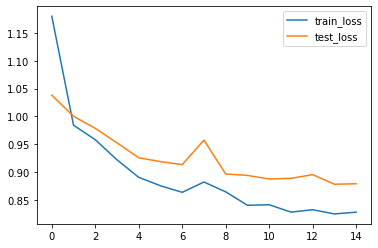

In [14]:
# plot the training and testing loss
plot_loss(train_loss_history, test_loss_history, 'Charnn')

In [15]:
# save the history to the csv file in log folder
history = pd.DataFrame({'train_loss': train_loss_history, 'train_acc': train_acc_history, 'test_loss': test_loss_history, 'test_acc': test_acc_history, 'train_ce_loss': train_ce_loss_history, 'test_ce_loss': test_ce_loss_history, 'train_info_loss': train_info_loss_history, 'test_info_loss': test_info_loss_history})
history.to_csv(log_dir + 'charnn_contrastive_history.csv', index=False)